In [1]:
import sys
from finenv.env_stocktrading import StockTradingEnv
from finenv.env_stocktrading_cut import StockTradingEnv2
from finenv.preprocessors import FeatureEngineer, data_split
import pandas as pd
import pickle 
import psutil
import ray, time
ray._private.utils.get_system_memory = lambda: psutil.virtual_memory().total
from ray.tune.registry import register_env
from gymnasium.wrappers import EnvCompatibility
from ray.rllib.agents import ppo
from ray.rllib.algorithms.ddpg.ddpg import DDPGConfig
from ray.rllib.algorithms.td3 import TD3Config
from ray.rllib.algorithms.algorithm import Algorithm


In [2]:
csv = True
if csv:
    trade = pd.read_csv('dataset/trade_data.csv')
    trade = trade.set_index(trade.columns[0])
    trade.index.names = ['']
    INDICATORS = ['macd','boll_ub','boll_lb','rsi_30','cci_30','dx_30','close_30_sma','close_60_sma']
    
else: 
    trade = pd.read_csv('dataset/qqq_train.csv')
    trade = trade.set_index(trade.columns[0])
    trade.index.names = ['']
    INDICATORS = ['macd','rsi','cci','adx']
    
stock_dimension = len(trade.tic.unique())
buy_cost_list = sell_cost_list = [0.001] * stock_dimension    
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")
trade.head(5)    

Stock Dimension: 82, State Space: 821


,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
,,,,,,,,,,,,,,,,,,
0,2019-05-13,AAL,33.160000,33.200001,31.980000,31.806322,7040900.0,0.0,0.068302,34.569498,32.334916,45.215427,-214.170697,27.605727,33.410860,32.926946,20.549999,66.279113
0,2019-05-13,AAPL,46.927502,47.369999,45.712502,45.109745,229722400.0,0.0,0.197157,51.926067,46.557554,45.444835,-217.008389,36.029204,48.727346,46.152760,20.549999,66.279113
0,2019-05-13,ADBE,270.570007,274.190002,267.220001,267.700012,2698300.0,0.0,1.817067,289.657626,265.629380,49.563237,-70.042576,11.671184,275.212335,267.923668,20.549999,66.279113
0,2019-05-13,ADI,107.139999,107.680000,103.660004,96.640236,4900300.0,0.0,-0.249283,110.952118,99.932762,44.527702,-209.619993,31.042926,104.556207,101.852575,20.549999,66.279113
0,2019-05-13,ADP,158.410004,159.729996,157.000000,144.804428,1898900.0,0.0,0.054466,153.079841,144.267400,51.116730,-122.031963,12.592402,148.526597,144.703038,20.549999,66.279113


In [3]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension
env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-2
}
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = None, risk_indicator_col= 'vix', **env_kwargs)
e_trade_gym2 = StockTradingEnv2(df = trade, **env_kwargs)

In [4]:
def env_creator_trading(env_config):
    # env_config is passed as {} and defaults are set here
    df = env_config.get('df', trade)  # changed from the training environment
    hmax = env_config.get('hmax', 100)
    initial_amount = env_config.get('initial_amount', 1000000)
    num_stock_shares = env_config.get('num_stock_shares', [0] * stock_dimension)
    buy_cost_pct = env_config.get('buy_cost_pct', buy_cost_list)
    sell_cost_pct = env_config.get('sell_cost_pct', sell_cost_list)
    state_space = env_config.get('state_space', 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension)
    stock_dim = env_config.get('stock_dim', stock_dimension)
    tech_indicator_list = env_config.get('tech_indicator_list', INDICATORS)
    action_space = env_config.get('action_space', stock_dimension)
    reward_scaling = env_config.get('reward_scaling', 1e-2)
    return EnvCompatibility(StockTradingEnv(
        df=df,
        hmax=hmax,
        initial_amount=initial_amount,
        num_stock_shares=num_stock_shares,
        buy_cost_pct=buy_cost_pct,
        sell_cost_pct=sell_cost_pct,
        state_space=state_space,
        stock_dim=stock_dim,
        tech_indicator_list=tech_indicator_list,
        action_space=action_space,
        reward_scaling=reward_scaling,
    ))

In [5]:
ray.shutdown()
#ray.init(address='auto')

In [6]:
# registering the environment to ray
register_env("finrl", env_creator_trading)
#trainer = ppo.PPOTrainer(env='finrl', config=config)
#config = ppo.PPOConfig()
config = TD3Config()
config = config.environment(env_config={'hmax':100,'initial_amount':1000000})
config = config.rollouts(num_rollout_workers=0) 
config = config.framework(framework="torch")
#config['seed'] = 0 
#config["model"]["fcnet_hiddens"] = [1024,1024]
trader = config.build(env='finrl') 

2023-04-11 08:32:18,299	INFO worker.py:1544 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8266 
2023-04-11 08:32:20,390	WARNING env.py:156 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
2023-04-11 08:32:20,391	WARNING env.py:166 -- Your env reset() method appears to take 'seed' or 'return_info' arguments. Note that these are not yet supported in RLlib. Seeding will take place using 'env.seed()' and the info dict will not be returned from reset.
/home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/gymnasium/spaces/box.py:227: UserWarning: WARN: Casting input x to numpy array.
  logger.warn("Casting input x to numpy array.")


In [7]:
#load model
cwd_checkpoint = 'model/org_td3_230411_25/checkpoint_000025'
trader = Algorithm.from_checkpoint(cwd_checkpoint)

(RolloutWorker pid=22728) /home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/gymnasium/spaces/box.py:227: UserWarning: WARN: Casting input x to numpy array.
(RolloutWorker pid=22728)   logger.warn("Casting input x to numpy array.")
(RolloutWorker pid=22765) /home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/gymnasium/spaces/box.py:227: UserWarning: WARN: Casting input x to numpy array.
(RolloutWorker pid=22765)   logger.warn("Casting input x to numpy array.")
(RolloutWorker pid=22735) /home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/gymnasium/spaces/box.py:227: UserWarning: WARN: Casting input x to numpy array.
(RolloutWorker pid=22735)   logger.warn("Casting input x to numpy array.")
(RolloutWorker pid=22721) 2023-04-11 08:32:29,545	WARNING env.py:156 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
(RolloutWorker pid=22721) 2023-04-11 08:32:29,545	WARNING 

In [8]:
def DRL_prediction(model, environment):
    start = time.time()
    """make a prediction"""
    state = environment.reset()
    for i in range(len(environment.df.index.unique())):
        action = model.compute_single_action(state, explore=False)
        #print(f'Test Took:{(time.time()-start)}s')
        state, reward, done, _ = environment.step(action)
        if i == (len(environment.df.index.unique()) - 1):
            account_memory = environment.save_asset_memory()
            actions_memory = environment.save_action_memory()
        if done:
            break
    print(f'Test Took:{(time.time()-start):.3f}s | Average Time:{((time.time()-start)/len(environment.df.index.unique())):.6f}s/Iterations')
    return account_memory, actions_memory

In [9]:
df_account_value, df_actions = DRL_prediction(model=trader, environment = e_trade_gym)
print('Final account value:'+str(df_account_value.iloc[-1]['account_value']))
model_filename = cwd_checkpoint[14:-18]
df_actions.to_csv(f'results/{model_filename}.csv', index=True)
df_actions.head(100)

day: 977, episode: 1
begin_total_asset: 1000000.00
end_total_asset: 1718599.76
total_reward: 718599.76
total_cost: 999.00
total_trades: 59593
Sharpe: 0.653
Test Took:8.262s | Average Time:0.008447s/Iterations
Final account value:1718599.763207707


,AAL,AAPL,ADBE,ADI,ADP,ADSK,ALGN,AMAT,AMD,AMGN,...,TXN,UAL,ULTA,VRSK,VRSN,VRTX,WBA,WDC,WYNN,XEL
date,,,,,,,,,,,,,,,,,,,,,
2019-05-13,0,0,100,0,0,0,100,100,100,100,...,100,100,100,100,0,100,100,0,100,100
2019-05-14,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,100
2019-05-15,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-05-16,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-05-17,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-09-26,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-09-27,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-09-30,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
#Total Trades
counts = (df_actions > 0).sum()
tdays = int(df_actions.shape[0])
print(f'Trades:{counts.sum()}\nTrade Days:{tdays}\nTrades Per Day:{counts.sum()/tdays:.2f}')
df_actions.sum()

Trades:71
Trade Days:977
Trades Per Day:0.07


AAL       0
AAPL      0
ADBE    100
ADI       0
ADP       0
       ... 
VRTX    100
WBA     100
WDC       0
WYNN    101
XEL     200
Length: 82, dtype: int64

In [11]:
import datetime
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')
perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./results/"+"perf_stats_all"+now+'.csv')

/home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


==============Get Backtest Results===========
Annual return          0.149733
Cumulative returns     0.718600
Annual volatility      0.270023
Sharpe ratio           0.653142
Calmar ratio           0.456632
Stability              0.549051
Max drawdown          -0.327909
Omega ratio            1.124289
Sortino ratio          0.908379
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.946042
Daily value at risk   -0.033320
dtype: float64


/home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


In [12]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^NDX", 
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (977, 8)
Annual return          0.150447
Cumulative returns     0.721784
Annual volatility      0.278863
Sharpe ratio           0.643124
Calmar ratio           0.423042
Stability              0.498593
Max drawdown          -0.355631
Omega ratio            1.120914
Sortino ratio          0.902704
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.898492
Daily value at risk   -0.034422
dtype: float64


/home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/finrl/meta/preprocessor/yahoodownloader.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)
/home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


==============Compare to NDX===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (977, 8)


/home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/finrl/meta/preprocessor/yahoodownloader.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)
/home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


Start date,2019-05-13
End date,2023-03-29
Total months,46
,Backtest
Annual return,14.973%
Cumulative returns,71.86%
Annual volatility,27.002%
Sharpe ratio,0.65
Calmar ratio,0.46
Stability,0.55
Max drawdown,-32.791%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,32.79,2021-11-09,2022-06-16,NaT,NaN
1,32.13,2020-02-19,2020-03-20,2020-06-05,78
2,11.67,2020-09-02,2020-09-23,2020-11-06,48
3,9.11,2021-02-16,2021-03-04,2021-04-09,39
4,8.50,2021-04-26,2021-05-12,2021-06-24,44


/home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/pyfolio/timeseries.py:541: FutureWarning: The default dtype for empty Series will be 'ob

Stress Events,mean,min,max
New Normal,0.07%,-12.26%,8.47%


/home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/pyfolio/timeseries.py:1230: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  period = returns_dupe.loc[start:end]


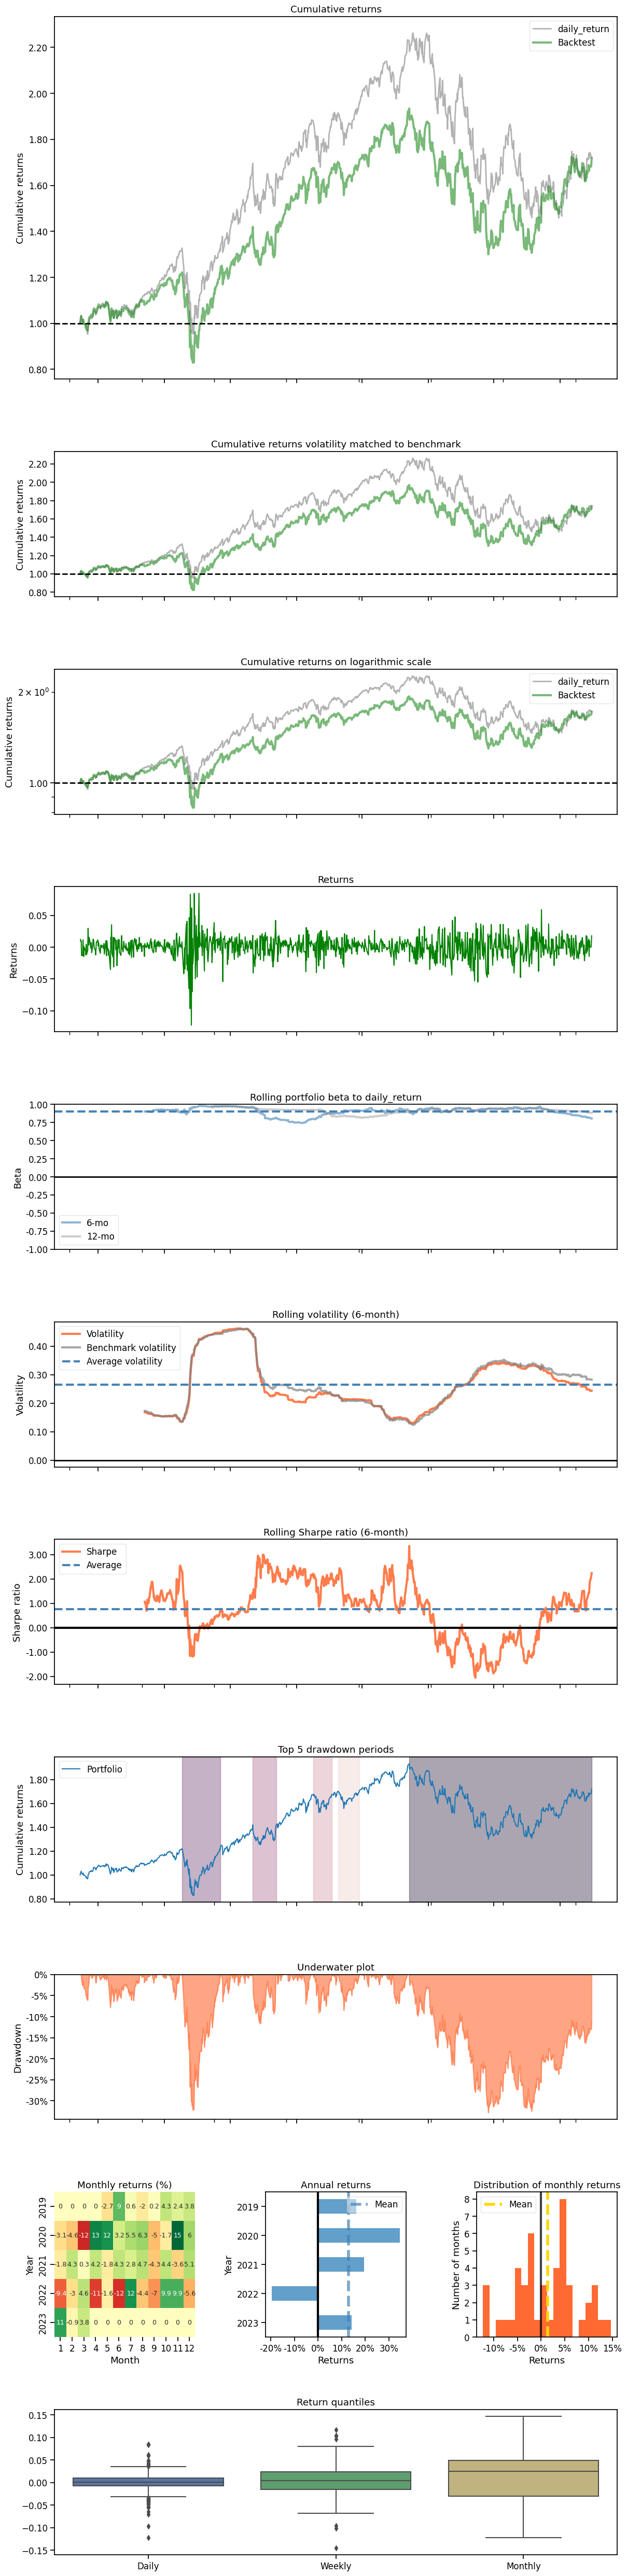

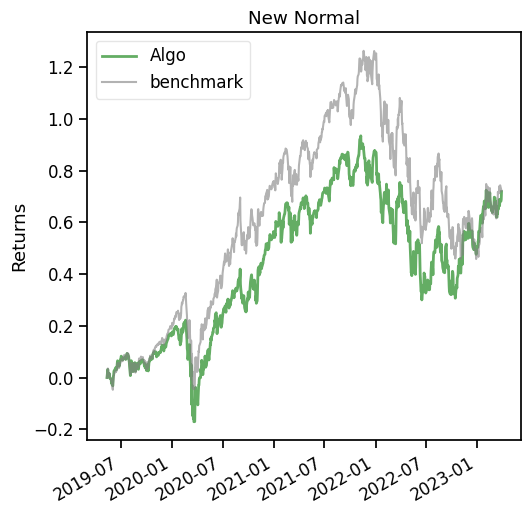

In [13]:
print("==============Compare to NDX===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
             baseline_ticker = '^NDX', 
             baseline_start = df_account_value.loc[0,'date'],
             baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])